In [2]:
# Creating a time series

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf ,plot_pacf
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
import math

In [4]:
df = sns.load_dataset('flights')
print(df)

     year month  passengers
0    1949   Jan         112
1    1949   Feb         118
2    1949   Mar         132
3    1949   Apr         129
4    1949   May         121
..    ...   ...         ...
139  1960   Aug         606
140  1960   Sep         508
141  1960   Oct         461
142  1960   Nov         390
143  1960   Dec         432

[144 rows x 3 columns]


In [5]:
df['yearMonth']=pd.to_datetime("01-"+df['month'].astype(str) + "-" +df['year'].astype(str)) # e.g. yearMonth will contain 01-01-1956,01-02-1956 ....
df.set_index('yearMonth',inplace=True)

In [6]:
airP=df[['passengers']].copy(deep=True)
print(airP)

            passengers
yearMonth             
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

[144 rows x 1 columns]


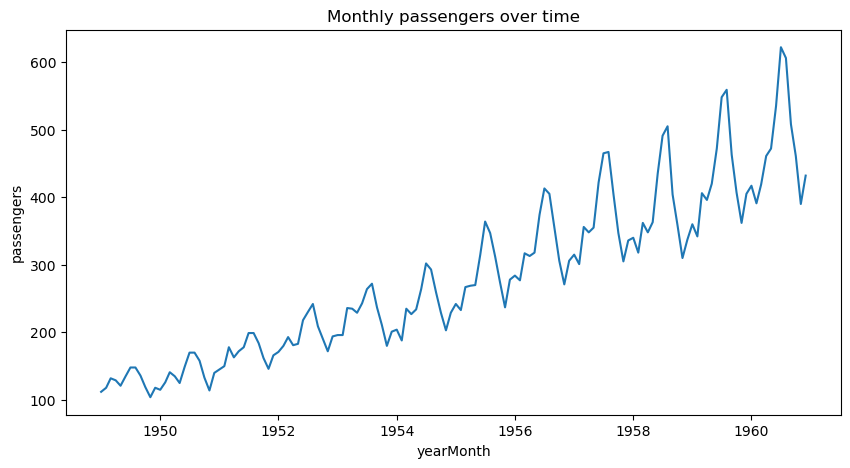

In [7]:
# Visualize initial data
plt.figure(figsize=(10,5))
sns.lineplot(x=airP.index,y=airP['passengers'])
plt.title("Monthly passengers over time")
plt.show()

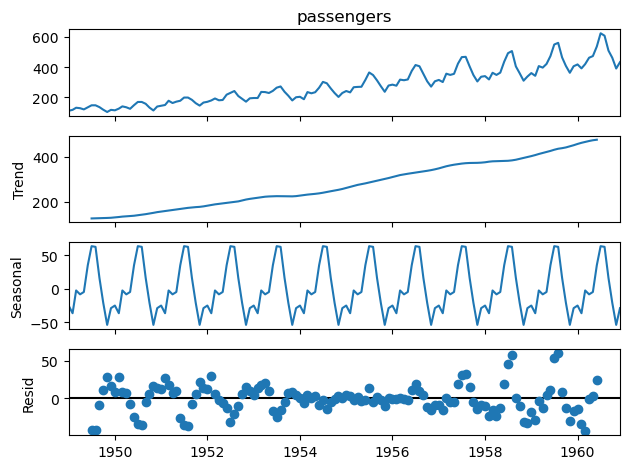

In [8]:
# Decompose to check trend and seasonality
decomposition = seasonal_decompose(airP.passengers, period=12)
decomposition.plot()
plt.show()

ADF p_value: 0.9919
The time series is not stationary (fail to reject H0).


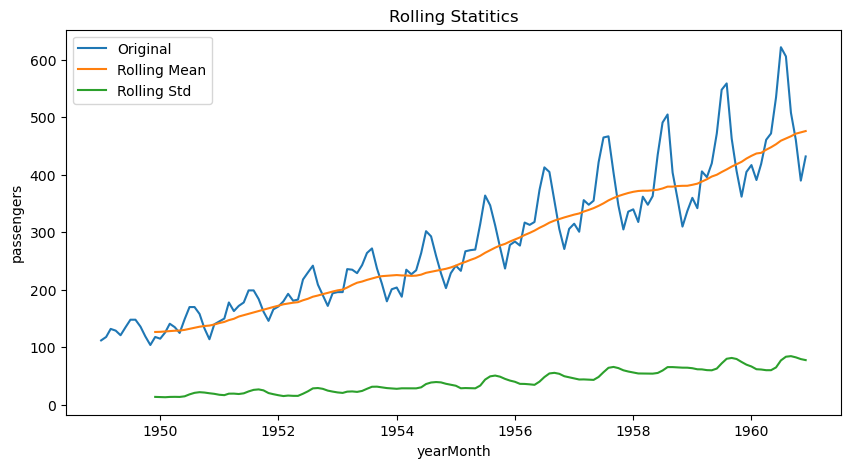

            passengers    rollMean    rollStd  shift  shiftDiff
yearMonth                                                      
1949-01-01         112         NaN        NaN    NaN        NaN
1949-02-01         118         NaN        NaN  112.0        6.0
1949-03-01         132         NaN        NaN  118.0       14.0
1949-04-01         129         NaN        NaN  132.0       -3.0
1949-05-01         121         NaN        NaN  129.0       -8.0
1949-06-01         135         NaN        NaN  121.0       14.0
1949-07-01         148         NaN        NaN  135.0       13.0
1949-08-01         148         NaN        NaN  148.0        0.0
1949-09-01         136         NaN        NaN  148.0      -12.0
1949-10-01         119         NaN        NaN  136.0      -17.0
1949-11-01         104         NaN        NaN  119.0      -15.0
1949-12-01         118  126.666667  13.720147  104.0       14.0
1950-01-01         115  126.916667  13.453342  118.0       -3.0
1950-02-01         126  127.583333  13.1

C:\Users\dbda.STUDENTSDC\AppData\Local\Temp\ipykernel_14692\305003607.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[var].rolling(window=window).mean()
C:\Users\dbda.STUDENTSDC\AppData\Local\Temp\ipykernel_14692\305003607.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollStd'] = dataFrame[var].rolling(window=window).std()


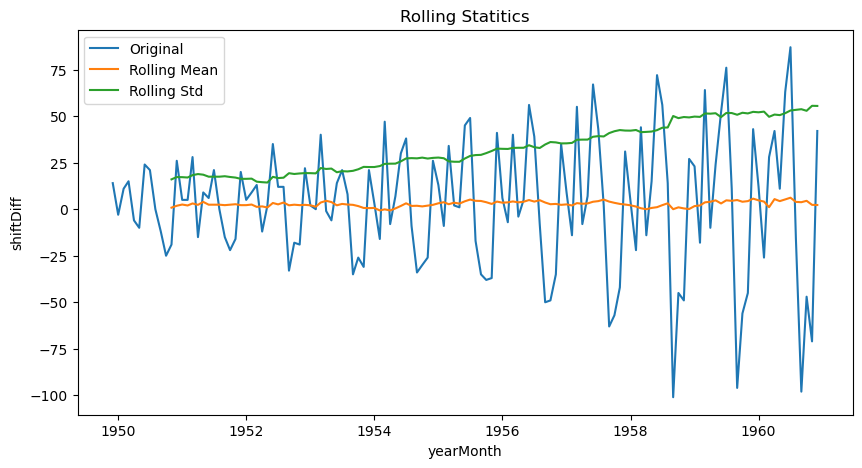

In [19]:
# To check whether our time series stationary or not
def test_stationary(dataFrame, var, window=12):
    dataFrame['rollMean'] = dataFrame[var].rolling(window=window).mean()
    dataFrame['rollStd'] = dataFrame[var].rolling(window=window).std()
    adf_result = adfuller(dataFrame[var])
    p_value = adf_result[1]

    print(f"ADF p_value: {p_value:.4f}")
    if p_value < 0.05:
        print("The time series is stationary (reject H0).")
    else:
        print("The time series is not stationary (fail to reject H0).")

    plt.figure(figsize=(10, 5))
    sns.lineplot(x=dataFrame.index, y=dataFrame[var], label='Original')
    sns.lineplot(x=dataFrame.index, y=dataFrame['rollMean'], label='Rolling Mean')
    sns.lineplot(x=dataFrame.index, y=dataFrame['rollStd'], label='Rolling Std')
    plt.title("Rolling Statitics")
    plt.legend()
    plt.show()
    
# Test Stationary
test_stationary(airP, 'passengers')

# Not stationary.....Try with diff of 1
airP['shift'] = airP.passengers.shift(1)
airP['shiftDiff'] = airP['passengers'] - airP['shift']
print(airP.head(20))
test_stationary(airP.dropna(), 'shiftDiff')


            passengers    rollMean    rollStd  shift  shiftDiff
yearMonth                                                      
1949-01-01         112         NaN        NaN    NaN        NaN
1949-02-01         118         NaN        NaN    NaN        NaN
1949-03-01         132         NaN        NaN  112.0       20.0
1949-04-01         129         NaN        NaN  118.0       11.0
1949-05-01         121         NaN        NaN  132.0      -11.0
1949-06-01         135         NaN        NaN  129.0        6.0
1949-07-01         148         NaN        NaN  121.0       27.0
1949-08-01         148         NaN        NaN  135.0       13.0
1949-09-01         136         NaN        NaN  148.0      -12.0
1949-10-01         119         NaN        NaN  148.0      -29.0
1949-11-01         104         NaN        NaN  136.0      -32.0
1949-12-01         118  126.666667  13.720147  119.0       -1.0
1950-01-01         115  126.916667  13.453342  104.0       11.0
1950-02-01         126  127.583333  13.1

C:\Users\dbda.STUDENTSDC\AppData\Local\Temp\ipykernel_14692\305003607.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[var].rolling(window=window).mean()
C:\Users\dbda.STUDENTSDC\AppData\Local\Temp\ipykernel_14692\305003607.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollStd'] = dataFrame[var].rolling(window=window).std()


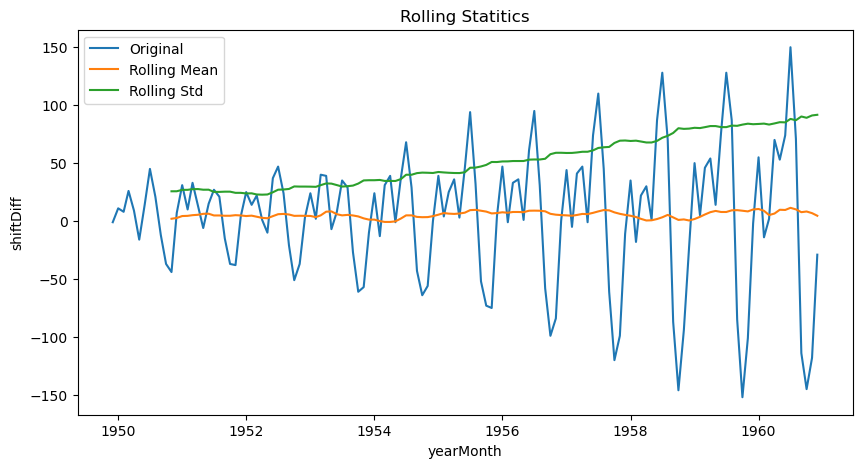

In [20]:
# since shiftdiff of 1 is not working, let us try with 2
airP['shift'] = airP.passengers.shift(2)
airP['shiftDiff'] = airP['passengers'] - airP['shift']
print(airP.head(20))
test_stationary(airP.dropna(), 'shiftDiff')

# ARIMA = Autoregressive integrated moving average

In [21]:
# For future prediction

In [22]:
# ACF

In [23]:
# For ACF - Differencing of 1 and 12
airP['firstDiff'] = airP['passengers'].diff()
airP['Diff12'] = airP['passengers'].diff(12)

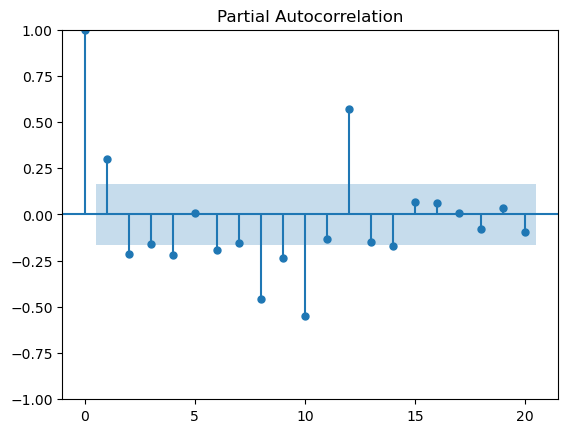

In [25]:
# PACF and ACF plots
plot_pacf(airP['firstDiff'].dropna(), lags=20)
plt.show()

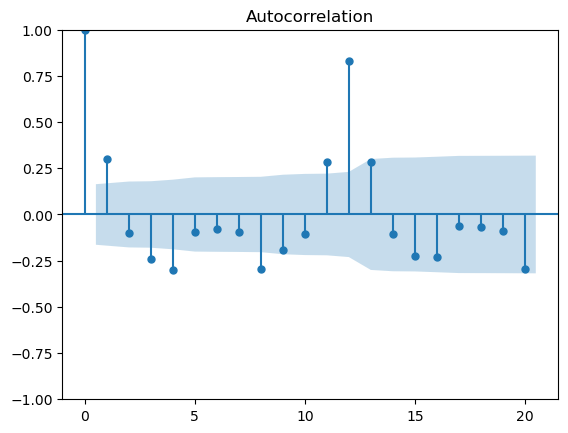

In [27]:
plot_acf(airP['firstDiff'].dropna(), lags=20)
plt.show()

In [28]:
# Train-Test Split
train_size = int(len(airP) * 0.7)
train = airP.iloc[:train_size]
test = airP.iloc[train_size:]

In [30]:
# ARIMA Model
model_arima = ARIMA(train['passengers'], order=(1,2,3,))
model_arima_fit = model_arima.fit()
arima_pred = model_arima_fit.predict(start=len(train), end=len(airP)-1)

C:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [31]:
# add ARIMA prediction to dataframe
airP['arimaPred'] = np.nan
airP.iloc[train_size:, airP.columns.get_loc('arimaPred')] = arima_pred.values
print(airP.tail())

            passengers    rollMean    rollStd  ...  firstDiff  Diff12   arimaPred
yearMonth                                      ...                               
1960-08-01         606  463.333333  83.630500  ...      -16.0    47.0  432.306345
1960-09-01         508  467.083333  84.617276  ...      -98.0    45.0  434.631535
1960-10-01         461  471.583333  82.541954  ...      -47.0    54.0  436.956728
1960-11-01         390  473.916667  79.502382  ...      -71.0    28.0  439.281918
1960-12-01         432  476.166667  77.737125  ...       42.0    27.0  441.607111

[5 rows x 8 columns]


In [32]:
# TO calculate P and Q for SARIMAX
airP['diff_combined'] = airP['passengers'].diff(2).diff(12)

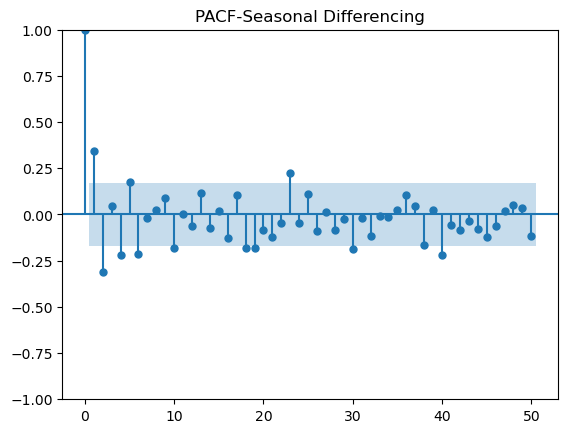

In [33]:
plot_pacf(airP['diff_combined'].dropna(), lags=50)
plt.title("PACF-Seasonal Differencing")
plt.show()

In [35]:
model_sarimax = SARIMAX(train['passengers'], order = (1,2,1), seasonal_order=(1,2,1,12))
model_sarimax_fit = model_sarimax.fit()
sarimax_pred = model_sarimax_fit.predict(start=len(train), end=len(airP)-1)

In [36]:
# Add SARIMAX prediction t dataframe
airP['sarimaxPred'] = np.nan
airP.iloc[train_size:, airP.columns.get_loc('sarimaxPred')] = sarimax_pred.values
print(airP.tail(20))

            passengers    rollMean  ...  diff_combined  sarimaxPred
yearMonth                           ...                            
1959-05-01         420  397.083333  ...           13.0   439.117682
1959-06-01         472  400.166667  ...          -11.0   509.164242
1959-07-01         548  404.916667  ...            0.0   562.993889
1959-08-01         559  409.416667  ...           17.0   546.783936
1959-09-01         463  414.333333  ...            2.0   482.330919
1959-10-01         407  418.333333  ...           -6.0   421.363755
1959-11-01         362  422.666667  ...           -7.0   375.133507
1959-12-01         405  428.333333  ...           20.0   420.645825
1960-01-01         417  433.083333  ...            5.0   431.777993
1960-02-01         391  437.166667  ...          -19.0   409.999522
1960-03-01         419  438.250000  ...          -44.0   476.379564
1960-04-01         461  443.666667  ...           16.0   466.832469
1960-05-01         472  448.000000  ...         

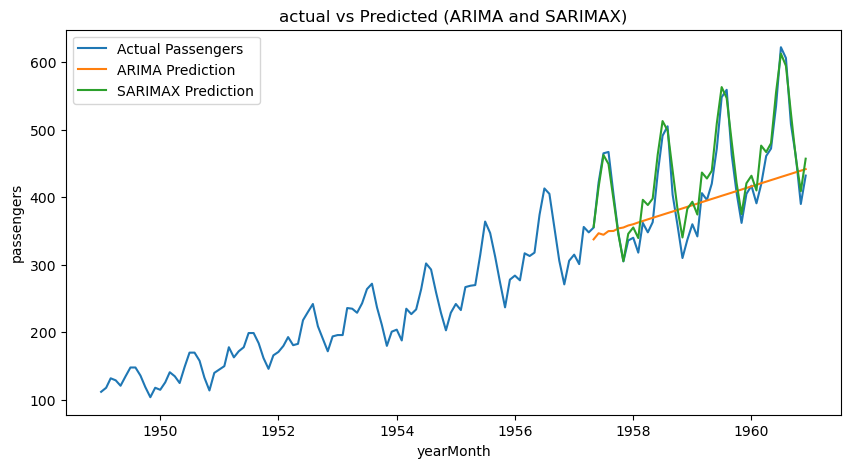

In [38]:
# Plot Predictions
plt.figure(figsize=(10,5))
sns.lineplot(x=airP.index, y=airP['passengers'], label='Actual Passengers')
sns.lineplot(x=airP.index, y=airP['arimaPred'], label='ARIMA Prediction')
sns.lineplot(x=airP.index, y=airP['sarimaxPred'], label='SARIMAX Prediction')
plt.title("actual vs Predicted (ARIMA and SARIMAX)")
plt.legend()
plt.show()

In [39]:
# Future Forecast using SARIMAX
future_dates = pd.DataFrame(pd.date_range(start='1961-01-01', end='1962-12-01', freq='MS'), columns = ['Dates'])
future_dates.set_index('Dates', inplace=True)

In [40]:
future_forecast = model_sarimax_fit.predict(start=future_dates.index[0], end=future_dates.index[-1])
print(future_forecast)

1961-01-01    468.924576
1961-02-01    444.061383
1961-03-01    515.018892
1961-04-01    504.539580
1961-05-01    519.266367
1961-06-01    599.651553
1961-07-01    660.635596
1961-08-01    640.470634
1961-09-01    564.483323
1961-10-01    494.146303
1961-11-01    440.984014
1961-12-01    491.725877
1962-01-01    504.306813
1962-02-01    476.344343
1962-03-01    551.704968
1962-04-01    540.269444
1962-05-01    556.574461
1962-06-01    642.020817
1962-07-01    706.522576
1962-08-01    684.264824
1962-09-01    602.439945
1962-10-01    527.340919
1962-11-01    470.609974
1962-12-01    523.894611
Freq: MS, Name: predicted_mean, dtype: float64


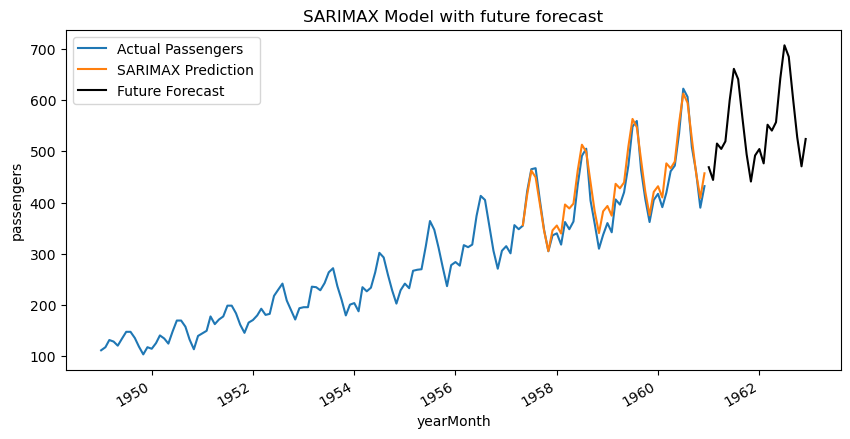

In [41]:
# Plot Future Forecast
plt.figure(figsize=(10,5))
sns.lineplot(x=airP.index, y=airP['passengers'], label='Actual Passengers')
sns.lineplot(x=airP.index, y=airP['sarimaxPred'], label='SARIMAX Prediction')
future_forecast.plot(color='black', label='Future Forecast')
plt.title("SARIMAX Model with future forecast")
plt.legend()
plt.show()

In [43]:
# Model Evaluation
airP = airP.dropna()

In [44]:
# Arima Metrics
arima_mae = mean_absolute_error(airP['passengers'], airP['arimaPred'])
arima_mse = mean_squared_error(airP['passengers'], airP['arimaPred'])
arima_rmse = math.sqrt(arima_mse)
arima_r2 = r2_score(airP['passengers'], airP['arimaPred'])
print(f"ARIMA -> MAE: {arima_mae:.2f}, RMSE:{arima_rmse:.2f}, R^2: {arima_r2:.2f}")

ARIMA -> MAE: 54.12, RMSE:73.46, R^2: 0.08


In [45]:
# SARIMAX Metrics
sarimax_mae = mean_absolute_error(airP['passengers'], airP['sarimaxPred'])
sarimax_mse = mean_squared_error(airP['passengers'], airP['sarimaxPred'])
sarimax_rmse = math.sqrt(sarimax_mse)
sarimax_r2 = r2_score(airP['passengers'], airP['sarimaxPred'])
print(f"SARIMAX -> MAE: {sarimax_mae:.2f}, RMSE:{sarimax_rmse:.2f}, R^2: {sarimax_r2:.2f}")

SARIMAX -> MAE: 19.75, RMSE:23.60, R^2: 0.90


In [66]:
# Problem: Perform Time Series Analysis on monthly-cola-production-in-austr.csv dataset.
# Creating a time series

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf ,plot_pacf
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
import math

In [67]:
import pandas as pd

df = pd.read_csv('monthly-cola-production-in-austr.csv')
print(df.head())  # Display the first few rows



     Month  cola
0  1956-01  93.2
1  1956-02  96.0
2  1956-03  95.2
3  1956-04  77.1
4  1956-05  70.9


             cola
Month            
1956-01-01   93.2
1956-02-01   96.0
1956-03-01   95.2
1956-04-01   77.1
1956-05-01   70.9
...           ...
1995-04-01  127.0
1995-05-01  151.0
1995-06-01  130.0
1995-07-01  119.0
1995-08-01  153.0

[476 rows x 1 columns]


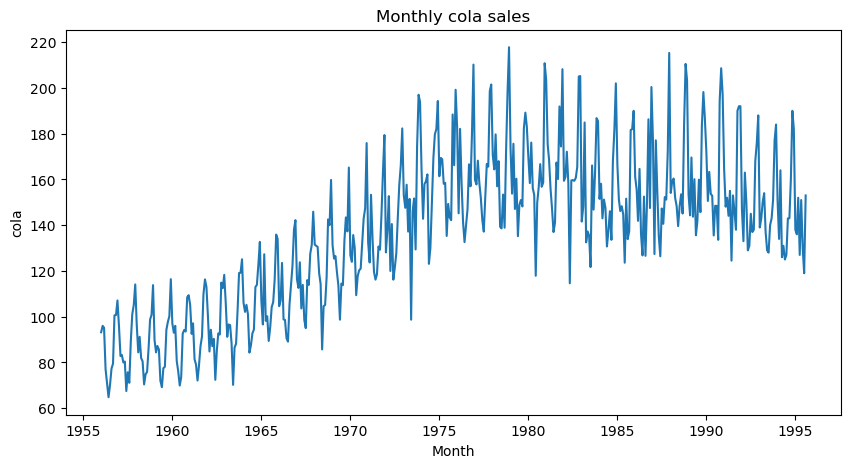

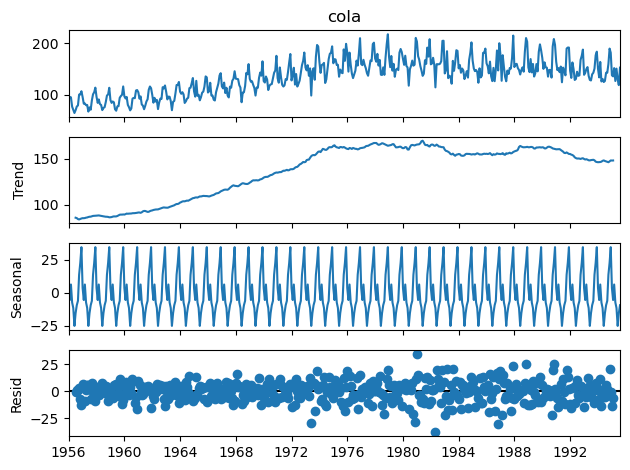

In [68]:
df['Month'] = pd.to_datetime(df['Month'].astype(str) + "-" + "01")
df.set_index('Month', inplace=True)

cola = df[['cola']].copy(deep=True)   # deep = true mens not a shallow copy
print(cola)

# Visualize initial data
plt.figure(figsize=(10,5))
sns.lineplot(x=cola.index,y=cola['cola'])
plt.title("Monthly cola sales")
plt.show()

# Decompose to check trend and seasonality
decomposition = seasonal_decompose(cola.cola, period=12)  # 12 for 1 year 
decomposition.plot()
plt.show()

ADF p_value: 0.1776
The time series is not stationary (fail to reject H0).


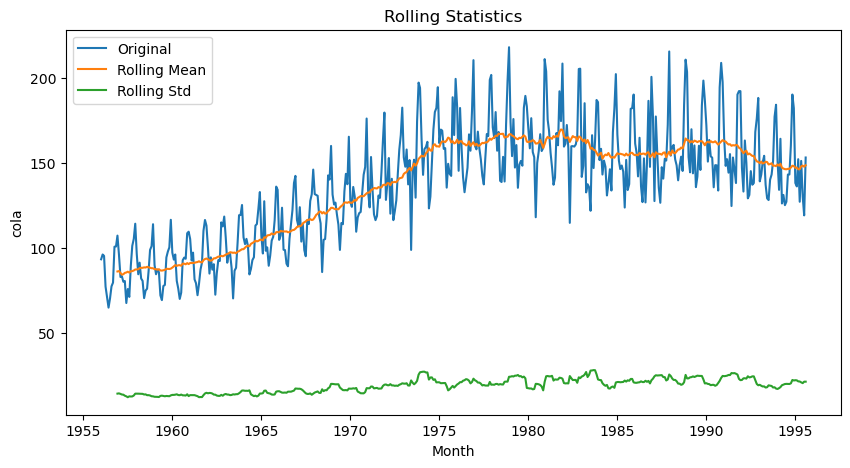

             cola  shift  shiftDiff
Month                              
1956-02-01   96.0   93.2        2.8
1956-03-01   95.2   96.0       -0.8
1956-04-01   77.1   95.2      -18.1
1956-05-01   70.9   77.1       -6.2
1956-06-01   64.8   70.9       -6.1
1956-07-01   70.1   64.8        5.3
1956-08-01   77.3   70.1        7.2
1956-09-01   79.5   77.3        2.2
1956-10-01  100.6   79.5       21.1
1956-11-01  100.7  100.6        0.1
1956-12-01  107.1  100.7        6.4
1957-01-01   95.9  107.1      -11.2
1957-02-01   82.8   95.9      -13.1
1957-03-01   83.3   82.8        0.5
1957-04-01   80.0   83.3       -3.3
1957-05-01   80.4   80.0        0.4
1957-06-01   67.5   80.4      -12.9
1957-07-01   75.7   67.5        8.2
1957-08-01   71.1   75.7       -4.6
1957-09-01   89.3   71.1       18.2
ADF p_value: 0.0000
The time series is stationary (reject H0).


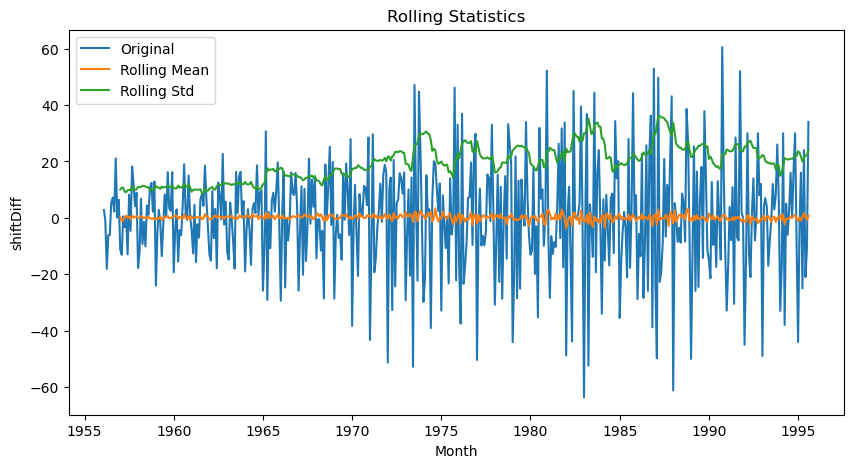

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Function to test stationarity
def test_stationary(dataFrame, var, window=12):
    dataFrame = dataFrame.copy()  # Prevent modifying original DataFrame
    dataFrame['rollMean'] = dataFrame[var].rolling(window=window).mean()
    dataFrame['rollStd'] = dataFrame[var].rolling(window=window).std()
    
    # Augmented Dickey-Fuller test
    adf_result = adfuller(dataFrame[var])
    p_value = adf_result[1]

    print(f"ADF p_value: {p_value:.4f}")
    if p_value < 0.05:
        print("The time series is stationary (reject H0).")
    else:
        print("The time series is not stationary (fail to reject H0).")

    # Visualization
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=dataFrame.index, y=dataFrame[var], label='Original')
    sns.lineplot(x=dataFrame.index, y=dataFrame['rollMean'], label='Rolling Mean')
    sns.lineplot(x=dataFrame.index, y=dataFrame['rollStd'], label='Rolling Std')
    plt.title("Rolling Statistics")
    plt.legend()
    plt.show()

# Load dataset (assuming it’s correctly imported as 'cola')
test_stationary(cola, 'cola')

# First-order differencing
cola['shift'] = cola['cola'].shift(1)
cola['shiftDiff'] = cola['cola'] - cola['shift']

# Drop NA values & test again
cola_cleaned = cola.dropna()
print(cola_cleaned.head(20))
test_stationary(cola_cleaned, 'shiftDiff')


C:\Users\dbda.STUDENTSDC\AppData\Local\Temp\ipykernel_14692\1759087226.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airP['shift'] = airP.passengers.shift(2)
C:\Users\dbda.STUDENTSDC\AppData\Local\Temp\ipykernel_14692\1759087226.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airP['shiftDiff'] = airP['passengers'] - airP['shift']


            passengers    rollMean  ...  diff_combined  sarimaxPred
yearMonth                           ...                            
1957-05-01         355  342.083333  ...           -2.0   356.064865
1957-06-01         422  346.083333  ...           13.0   415.079097
1957-07-01         465  350.416667  ...           15.0   462.365169
1957-08-01         467  355.583333  ...           14.0   449.225030
1957-09-01         404  359.666667  ...           -3.0   396.623902
1957-10-01         347  363.083333  ...          -21.0   345.165664
1957-11-01         305  365.916667  ...          -15.0   305.321393
1957-12-01         336  368.416667  ...          -11.0   345.879422
1958-01-01         340  370.500000  ...           -9.0   355.202415
1958-02-01         318  371.916667  ...          -13.0   339.608548
1958-03-01         362  372.416667  ...          -19.0   396.166601
1958-04-01         348  372.416667  ...          -17.0   388.458799
1958-05-01         363  373.083333  ...         

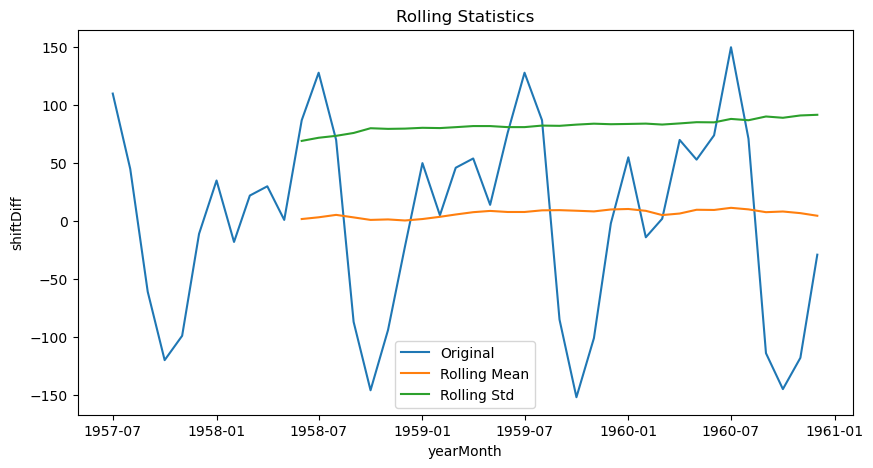

In [70]:
# since shiftdiff of 1 is not working, let us try with 2
airP['shift'] = airP.passengers.shift(2)
airP['shiftDiff'] = airP['passengers'] - airP['shift']
print(airP.head(20))
test_stationary(airP.dropna(), 'shiftDiff')

ADF p_value: 0.1776
The time series is not stationary (fail to reject H0).


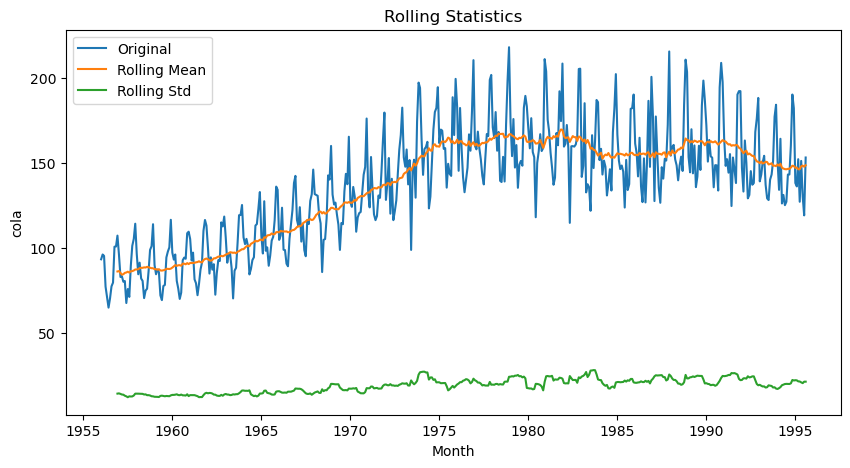

<Figure size 1200x500 with 0 Axes>

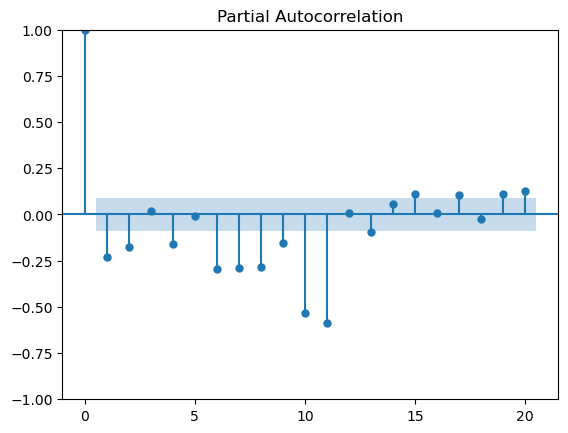

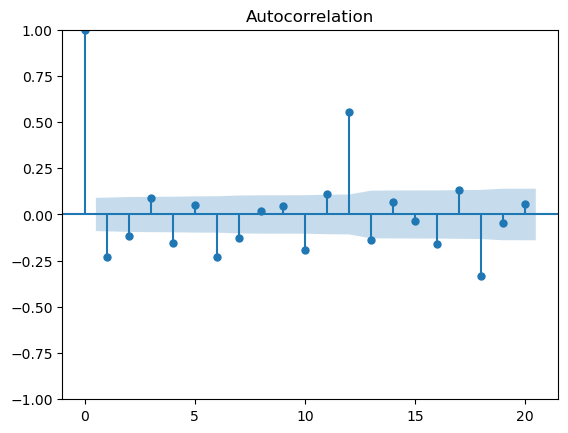

             cola  shift  shiftDiff  firstDiff  Diff12   arimaPred
Month                                                             
1995-04-01  127.0  152.0      -25.0      -25.0     1.0  157.692737
1995-05-01  151.0  127.0       24.0       24.0    20.0  157.692737
1995-06-01  130.0  151.0      -21.0      -21.0     5.0  157.692737
1995-07-01  119.0  130.0      -11.0      -11.0    -8.0  157.692737
1995-08-01  153.0  119.0       34.0       34.0    10.0  157.692737


C:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [73]:

# Test Stationarity on Original Data
test_stationary(cola, 'cola')

# First-order and Seasonal Differencing
cola['firstDiff'] = cola['cola'].diff()
cola['Diff12'] = cola['cola'].diff(12)

# ACF and PACF plots
plt.figure(figsize=(12, 5))
plot_pacf(cola['firstDiff'].dropna(), lags=20)
plt.show()

plot_acf(cola['firstDiff'].dropna(), lags=20)
plt.show()

# Train-Test Split
train_size = int(len(cola) * 0.7)
train, test = cola.iloc[:train_size], cola.iloc[train_size:]

# ARIMA Model (Verify order based on ACF/PACF)
model_arima = ARIMA(train['cola'].dropna(), order=(1,1,3))  # Use d=1 if differencing applied
model_arima_fit = model_arima.fit()
arima_pred = model_arima_fit.predict(start=len(train), end=len(cola)-1)

# Adding ARIMA Predictions
cola['arimaPred'] = np.nan
cola.iloc[train_size:, cola.columns.get_loc('arimaPred')] = arima_pred.values

# Display final dataset
print(cola.tail())


C:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


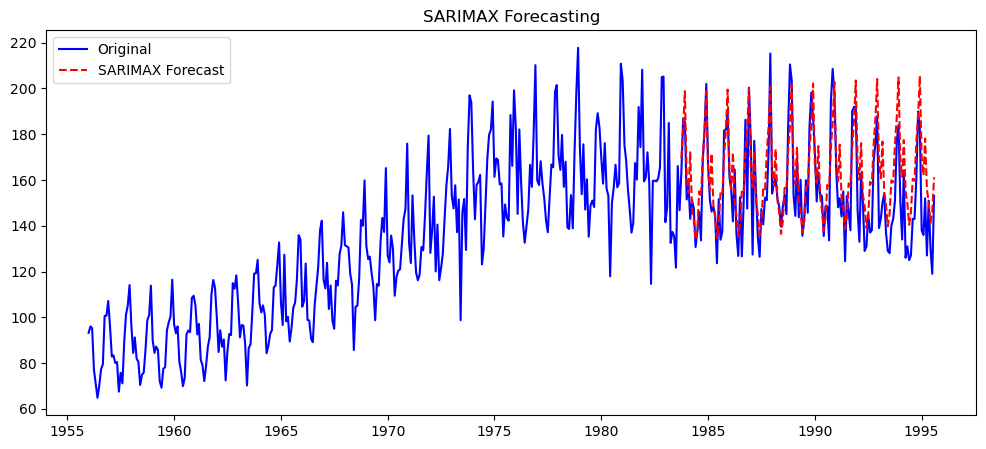

                                     SARIMAX Results                                      
Dep. Variable:                               cola   No. Observations:                  333
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1183.492
Date:                            Mon, 02 Jun 2025   AIC                           2376.983
Time:                                    12:14:42   BIC                           2395.825
Sample:                                01-01-1956   HQIC                          2384.507
                                     - 09-01-1983                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1104      0.044     -2.514      0.012      -0.196      -0.024
ma.L1         -0.8862      0.023   

In [74]:

# Train-Test Split
train_size = int(len(cola) * 0.7)
train, test = cola.iloc[:train_size], cola.iloc[train_size:]

# Seasonal ARIMA Model (p,d,q) x (P,D,Q,s)
sarimax_model = SARIMAX(train['cola'], 
                        order=(1,1,1),  # Non-seasonal ARIMA(p,d,q)
                        seasonal_order=(1,1,1,12))  # Seasonal (P,D,Q,s)

# Fit SARIMAX Model
sarimax_fit = sarimax_model.fit()

# Forecast
sarimax_pred = sarimax_fit.predict(start=len(train), end=len(cola)-1)

# Add Predictions to DataFrame
cola['sarimaxPred'] = np.nan
cola.iloc[train_size:, cola.columns.get_loc('sarimaxPred')] = sarimax_pred.values

# Plot Results
plt.figure(figsize=(12, 5))
plt.plot(cola.index, cola['cola'], label='Original', color='blue')
plt.plot(cola.index, cola['sarimaxPred'], label='SARIMAX Forecast', color='red', linestyle='dashed')
plt.title("SARIMAX Forecasting")
plt.legend()
plt.show()

# Model Summary
print(sarimax_fit.summary())


In [75]:
# Q.Perform Time series Analysis on gold_price_data.csv dataset.

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [80]:
# Load dataset
df = pd.read_csv('gold_price_data.csv')

# Display basic details
print(df.head())



         Date  Value
0  1970-01-01   35.2
1  1970-04-01   35.1
2  1970-07-01   35.4
3  1970-10-01   36.2
4  1971-01-01   37.4


In [78]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

KeyError: 'Date'

#  Simulation

# Monte Carlo Simulation (What if analysis):

In [84]:
import numpy as np

In [85]:
# Part 1
def roll_dice():
    # Simulation of rolling a dice twice, minimum number we get is 1, max is 6
    # add the results of two simulation, so possible values will be:
    # (1,1) or (1,2) ... (6,6) ,....sum will be between 2 and 12
    # Run multiple times to verify
    return np.sum(np.random.randint(1,7,2)) # Generate an array of 2 random intergers between 1 and 6 (both inclusive) and add them 

print(roll_dice())

8


In [86]:
# part 2
# someone approaches us saying I will give you 5 dollars if you get 7 and take 1 dollar if you get a number other than 7
# How do we know what will happen? Our own "Monte Carlo Simulation" like function 
def monte_carlo_simulation(runs=1000):
    results = np.zeros(2)     # an array, results[0] and results [1] initialized to two zeroes
    for _ in range(runs):
        if roll_dice() == 7:
            results[0] += 1
        else:
            results[1] += 1
    return results

In [97]:
# Test 2-3 times and calculate how much you will win versus lose
print(monte_carlo_simulation())
print(monte_carlo_simulation())
print(monte_carlo_simulation())

[160. 840.]
[174. 826.]
[188. 812.]


In [98]:
# Part 3: Now do it 1000 times ....Takes some time
results = np.zeros(1000)
for i in range(1000):
    results[i] = monte_carlo_simulation()[0]
print(results)

[159. 163. 158. 184. 163. 175. 176. 143. 178. 165. 178. 165. 181. 162.
 161. 150. 168. 167. 166. 177. 171. 166. 172. 181. 168. 144. 168. 178.
 155. 182. 167. 167. 162. 175. 186. 145. 157. 160. 160. 178. 182. 170.
 161. 171. 166. 167. 171. 174. 165. 177. 156. 168. 170. 170. 195. 156.
 169. 169. 182. 178. 186. 157. 157. 152. 165. 168. 157. 177. 175. 169.
 179. 169. 169. 190. 161. 164. 158. 162. 166. 178. 178. 163. 165. 182.
 168. 151. 157. 168. 179. 165. 174. 168. 177. 147. 155. 174. 192. 174.
 167. 172. 151. 174. 171. 182. 178. 158. 177. 182. 160. 143. 165. 170.
 182. 175. 183. 153. 182. 171. 167. 171. 192. 170. 185. 176. 182. 174.
 172. 145. 170. 172. 144. 174. 186. 176. 177. 175. 159. 181. 177. 194.
 183. 165. 172. 147. 150. 184. 163. 167. 156. 155. 160. 169. 164. 159.
 167. 171. 151. 187. 160. 154. 198. 155. 168. 168. 183. 193. 164. 165.
 156. 164. 144. 168. 160. 170. 191. 169. 171. 150. 173. 161. 175. 146.
 162. 171. 167. 161. 180. 171. 163. 153. 159. 142. 187. 182. 157. 172.
 152. 

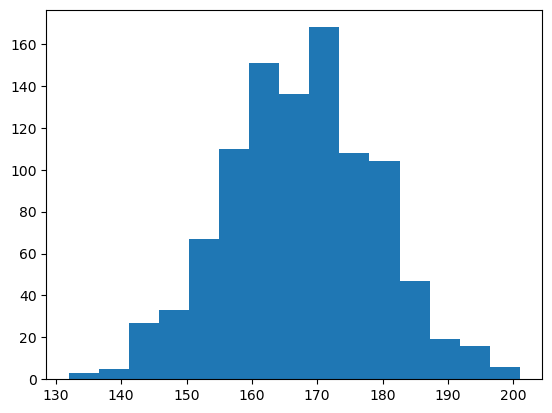

In [99]:
# Let us plot it
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(results, bins=15)
plt.show()

In [100]:
# Our win/loss
print(results.mean())    # General mean
print(results.mean()*5)  # What we will get an win on an average
print(results.mean() * 4.75)  # Just a marginal change in reward - see the impact
print(1000 - results.mean())  # What we will pay on an average
print(results.mean()/1000)   # Probability of the 'we will win' result
# The last probability should be close to the theretical probability of getting a 7 when we throw two dice 
# (why? 1+6, 2+5, 3+4, 5+2, 6+1 = 6 OUT OF 36 States)

167.403
837.015
795.1642499999999
832.597
0.167403


# Investment Risk analysis using Monte Carlo

In [101]:
import numpy as np
import matplotlib.pyplot as plt

In [102]:
# Parameters
initial_investments = 10000    # Initial investment in dollar
mean_return = 0.15             # Expected annual return
std_dev = 0.15                 # Std deviation of returns
num_simulation = 1000          # No of Monte calrlo simulation

In [107]:
# Monte carlo simualtion
simulated_end_values = []
for _ in range(num_simulation):
    # Generate a random annual return for each simulation
    random_return  = np.random.normal(mean_return, std_dev)
    print(random_return)
    # End value at the end of one year of investment
    end_value = initial_investments * (1+random_return)
    # Store it in list
    simulated_end_values.append(end_value)
print(simulated_end_values)

0.1767851928959974
-0.027349699716159526
0.17753342572934167
-0.09682827728943105
0.0398755511297916
0.4431289603456833
0.16242639564197153
0.2970747024400239
0.17319414933993416
0.19658419447948988
0.2291641803946699
-0.08768777074735876
0.09655183155665048
-0.1079152207785837
0.17517988605556423
0.0956831575114446
0.22651675442410996
0.24123362641229695
-0.24083840093081613
0.02090149154205309
0.011790908086905333
0.23334889936615383
0.22655807540306258
0.0745991561614635
0.12775349220742435
-0.028801029772603903
0.4489578670478467
0.3059210610793369
-0.11366837672013333
0.17057958665665718
0.1665608225854666
-0.14033146295189255
0.1626362766801794
0.03415176623445404
0.32119781860926405
0.22884636658327245
0.2306114722889342
0.16000825490227552
0.31819531318965866
0.07846874591651218
0.4491103313862167
0.2028079107719944
0.30541379668908863
-0.057821393434376256
0.22249294957464888
0.06399450156381588
0.0665544782107817
0.23996326735570056
0.22034522073121846
0.17420509091683614
0.0

In [108]:
# Results 
mean_end_value = np.mean(simulated_end_values)  # mean of all simulated end values
# Proportion of cases where we have a loss (End annual value < Initial Investment)
risk_of_loss = np.mean(np.array(simulated_end_values) < initial_investments)

print(f"Mean end values: ${mean_end_value:.2f}")
print(f"probability of loss:{risk_of_loss * 100:.2f}%") 

Mean end values: $11547.49
probability of loss:16.00%


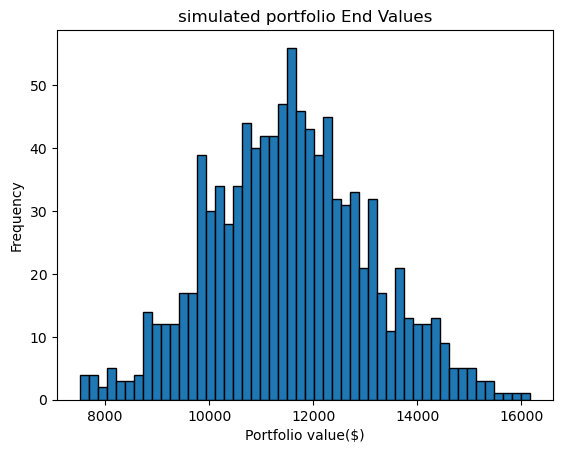

In [110]:
# Plotting the distribution
plt.hist(simulated_end_values, bins=50, edgecolor='k')
plt.title("simulated portfolio End Values")
plt.xlabel("Portfolio value($)")
plt.ylabel("Frequency")
plt.show()

In [119]:
# Problem: Download stock price data for Apple from the beginning
pip install yfinance
import yfinance as yf
aapl = yf.Ticker("AAPL")
df = aapl.history(period="max")
print(df.to_string())
# Use monte carlo to simulate the investment value after a year if someone invests $10,000 in the stock today. 

SyntaxError: invalid syntax (1329294973.py, line 2)

In [117]:
pip install yfinance

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     -------------------------------------- - 2.9/3.0 MB 21.0 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 10.4 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 9.2 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.18.1-py3-none-any.whl size=139097 sha256=e712b1025282f3ba05aebfac5d962afff8662b5465923ac251488294fd7b1221
  Stored in directory: c:\users\dbda.studentsdc\appdata\local\pip\cache\wheels\1a\57\6a\bb71346381d0d911cd4ce3026f1fa720da76707e4f01cf27dd
Succe

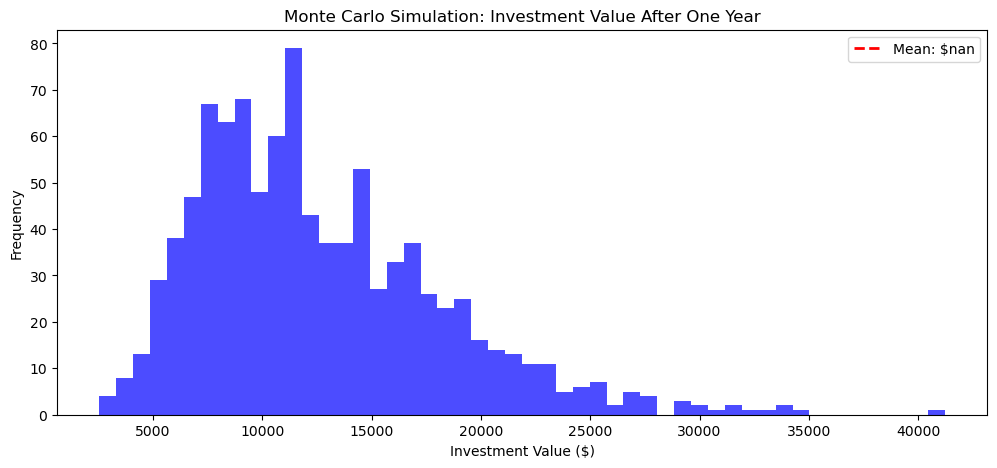

Expected Investment Value After 1 Year: $nan


In [118]:

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Download Apple's stock price history
aapl = yf.Ticker("AAPL")
df = aapl.history(period="max")

# Calculate Daily Returns
df['daily_return'] = df['Close'].pct_change().dropna()

# Monte Carlo Simulation Parameters
num_simulations = 1000  # Number of random trials
num_days = 252  # Trading days in a year
initial_investment = 10000  # Investment amount

# Run Monte Carlo Simulation
simulations = []
for _ in range(num_simulations):
    simulated_prices = [df['Close'].iloc[-1]]  # Start with last known price
    for _ in range(num_days):
        simulated_prices.append(simulated_prices[-1] * (1 + np.random.choice(df['daily_return'])))
    final_price = simulated_prices[-1]
    simulations.append(final_price)

# Convert simulations to investment values
simulated_values = [initial_investment * (price / df['Close'].iloc[-1]) for price in simulations]

# Plot the results
plt.figure(figsize=(12, 5))
plt.hist(simulated_values, bins=50, color='blue', alpha=0.7)
plt.axvline(np.mean(simulated_values), color='red', linestyle='dashed', linewidth=2, label=f"Mean: ${np.mean(simulated_values):.2f}")
plt.title("Monte Carlo Simulation: Investment Value After One Year")
plt.xlabel("Investment Value ($)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Print expected final investment value
print(f"Expected Investment Value After 1 Year: ${np.mean(simulated_values):.2f}")


In [120]:
# In addition to above, Also try Time series Analysis for stock price prediction (although TSA ay not work well for stock price data)

In [121]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Download Apple's stock price history
aapl = yf.Ticker("AAPL")
df = aapl.history(period="max")

# Keep only closing prices
df = df[['Close']]
df.dropna(inplace=True)

# Convert date index
df.index = pd.to_datetime(df.index)
print(df.head())


                              Close
Date                               
1980-12-12 00:00:00-05:00  0.098597
1980-12-15 00:00:00-05:00  0.093453
1980-12-16 00:00:00-05:00  0.086594
1980-12-17 00:00:00-05:00  0.088737
1980-12-18 00:00:00-05:00  0.091310


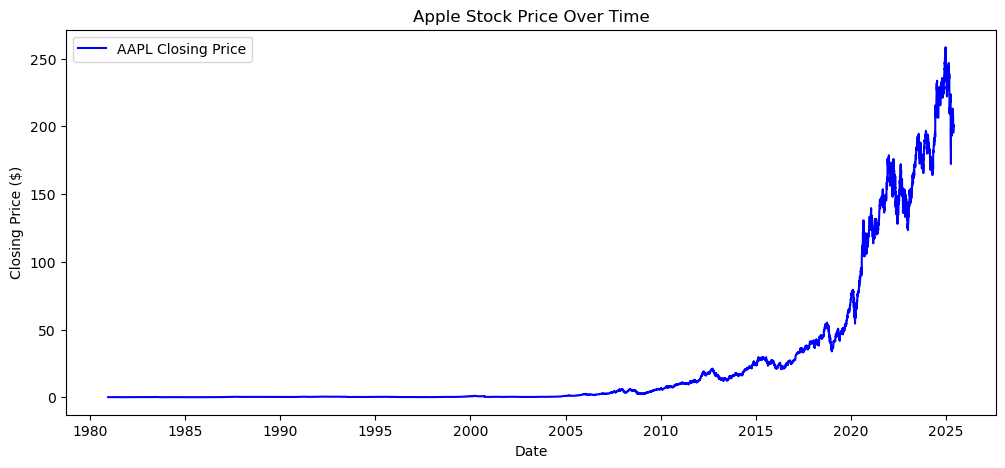

In [122]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Close'], label='AAPL Closing Price', color='blue')
plt.title("Apple Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price ($)")
plt.legend()
plt.show()


In [123]:
def test_stationarity(series):
    result = adfuller(series)
    print(f"ADF Test Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] < 0.05:
        print("✅ Time series is stationary (reject H0)")
    else:
        print("❌ Time series is NOT stationary (fail to reject H0)")

test_stationarity(df['Close'])


ADF Test Statistic: 2.0179
p-value: 0.9987
❌ Time series is NOT stationary (fail to reject H0)


In [124]:
df['Close_Diff'] = df['Close'].diff().dropna()
test_stationarity(df['Close_Diff'])


MissingDataError: exog contains inf or nans

<Figure size 1200x500 with 0 Axes>

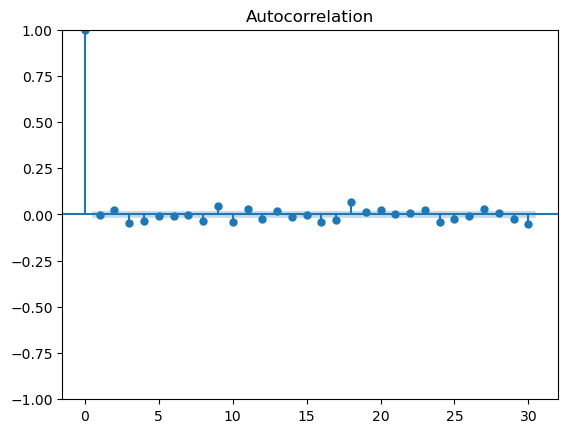

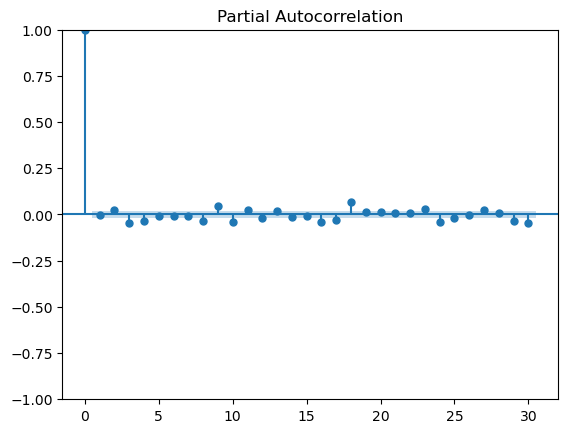

In [125]:
plt.figure(figsize=(12, 5))
plot_acf(df['Close_Diff'].dropna(), lags=30)
plot_pacf(df['Close_Diff'].dropna(), lags=30)
plt.show()


In [126]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]


In [127]:
# ARIMA Model based on ACF/PACF observations
model_arima = ARIMA(train['Close'], order=(1,1,1))  # Adjust order after analysis
model_arima_fit = model_arima.fit()
arima_pred = model_arima_fit.predict(start=len(train), end=len(df)-1)

# Add Predictions
df['ARIMA_Pred'] = np.nan
df.iloc[train_size:, df.columns.get_loc('ARIMA_Pred')] = arima_pred.values


C:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [129]:
# Seasonal SARIMA Model
model_sarimax = SARIMAX(train['Close'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_sarimax_fit = model_sarimax.fit()
sarimax_pred = model_sarimax_fit.predict(start=len(train), end=len(df)-1)

# Add Predictions
df['SARIMAX_Pred'] = np.nan
df.iloc[train_size:, df.columns.get_loc('SARIMAX_Pred')] = sarimax_pred.values

C:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


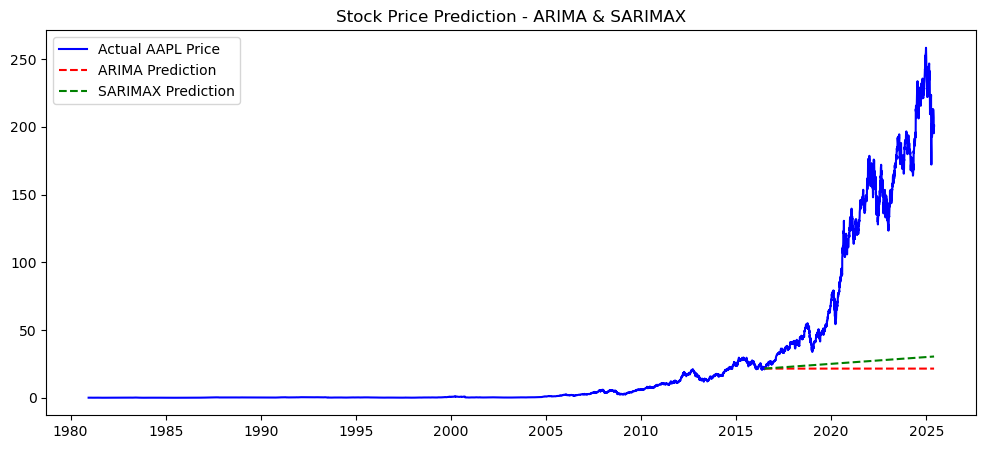

In [130]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Close'], label='Actual AAPL Price', color='blue')
plt.plot(df.index, df['ARIMA_Pred'], label='ARIMA Prediction', color='red', linestyle='dashed')
plt.plot(df.index, df['SARIMAX_Pred'], label='SARIMAX Prediction', color='green', linestyle='dashed')
plt.title("Stock Price Prediction - ARIMA & SARIMAX")
plt.legend()
plt.show()


In [131]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("ARIMA Model Evaluation:")
print(f"MAE: {mean_absolute_error(test['Close'], arima_pred)}")
print(f"MSE: {mean_squared_error(test['Close'], arima_pred)}")

print("\nSARIMAX Model Evaluation:")
print(f"MAE: {mean_absolute_error(test['Close'], sarimax_pred)}")
print(f"MSE: {mean_squared_error(test['Close'], sarimax_pred)}")


ARIMA Model Evaluation:
MAE: 89.68017793041675
MSE: 12509.795431173168

SARIMAX Model Evaluation:
MAE: 85.20846609095071
MSE: 11401.401524095681


In [133]:
import pandas as pd
# Step 1: Load Data and identify feature and label
df = pd.read_csv('salary.csv')
X = df[['YearsExperience']] # X has to be a DataFrame , single square bracket will give SERIES, which fit function wont accept.
y = df[['Salary']]

# Step 2: Split data into training and testing 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=0)

# Print X and y for the test set
print("-----Test Set Data----")
print("X_test (Experience): \n", X_test)
print("\ny_test (Salary):\n", y_test)
print("---------------\n")

# Step 3 : Fit Simple linear Regression to Training Data
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)


-----Test Set Data----
X_test (Experience): 
     YearsExperience
2               1.5
28             10.3
13              4.1
10              3.9
26              9.5
24              8.7

y_test (Salary):
       Salary
2    37731.0
28  122391.0
13   57081.0
10   63218.0
26  116969.0
24  109431.0
---------------



LinearRegression()

Predicted values on test set :  [[ 40748.96184072]
 [122699.62295594]
 [ 64961.65717022]
 [ 63099.14214487]
 [115249.56285456]
 [107799.50275317]]


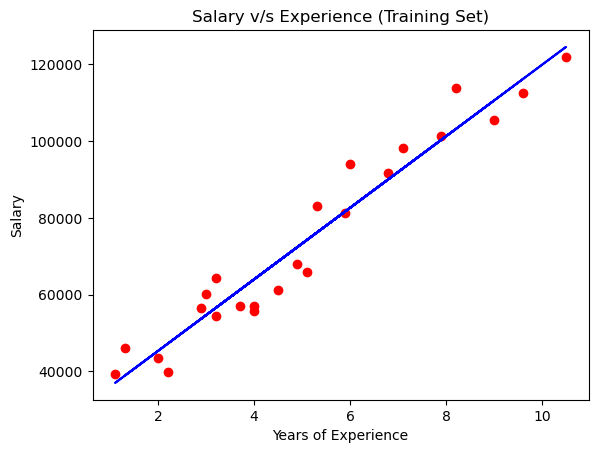

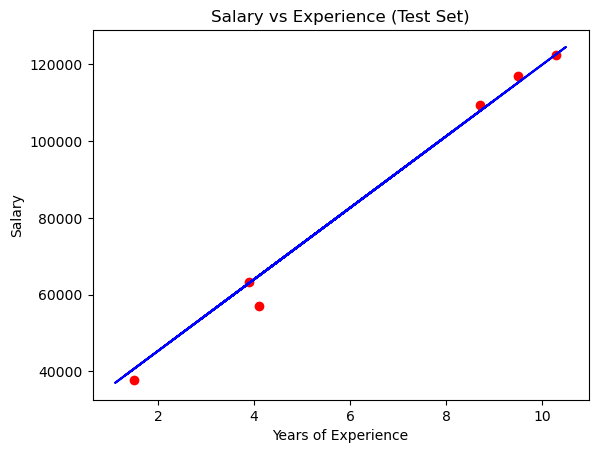

In [134]:
# Step 4: Make Prediction
y_pred = model.predict(X_test)
print("Predicted values on test set : ", y_pred)

# Step 5 : Visualize training set results
import matplotlib.pyplot as plt
plt.scatter(X_train, y_train, color='red')
plt.plot(X_train, model.predict(X_train), color='blue')
plt.title('Salary v/s Experience (Training Set)')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.show()

# sTep 6:  Visualize the test set results
plt.scatter(X_test, y_test, color='red')
plt.plot(X_train, model.predict(X_train), color = 'blue') # Same regression line
plt.title('Salary vs Experience (Test Set)')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.show()

In [135]:
#Step 7 : Make new prediction
new_X_values_df = pd.DataFrame({'YearsExperience':[1,3,5,8,12,15,20,25]})
new_y_pred = model.predict(new_X_values_df)
print('\nPredictions for new experience values (1,3,5,8,12,15,20,25): \n', new_y_pred)

# Step 8 : Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics : ")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE) : ", mse)
print("R2 Score : ", r2)



Predictions for new experience values (1,3,5,8,12,15,20,25): 
 [[ 36092.67427736]
 [ 54717.82453082]
 [ 73342.97478427]
 [101280.70016446]
 [138531.00067138]
 [166468.72605157]
 [213031.60168521]
 [259594.47731886]]

Model Evaluation Metrics : 
Mean Absolute Error (MAE): 2446.1723690465064
Mean Squared Error (MSE) :  12823412.298126562
R2 Score :  0.988169515729126


# Saving Model( and anything else as pickle file)

In [136]:
import joblib
joblib.dump(model, 'final_salary_model.pkl')
joblib.dump(list(X.columns), 'salary_column_names.pkl')

['salary_column_names.pkl']

In [137]:
# let us say we need this model some time later...
# Loading model (Model Persistence)
col_names = joblib.load('salary_column_names.pkl')
loaded_model = joblib.load('final_salary_model.pkl')

In [139]:
# make new prediction using the loaded model
print("*** Making predictions for new data using loaded model***")
new_experience_years_for_predictions = [1.5, 4, 8, 12, 15, 20, 25]

for new_experience_years in new_experience_years_for_predictions:
    new_salary_pred = loaded_model.predict(pd.DataFrame({'YearsExperience':[new_experience_years]}))
    print(f"Experience in years: {new_experience_years}....Predicted salary: {new_salary_pred}")

*** Making predictions for new data using loaded model***
Experience in years: 1.5....Predicted salary: [[40748.96184072]]
Experience in years: 4....Predicted salary: [[64030.39965754]]
Experience in years: 8....Predicted salary: [[101280.70016446]]
Experience in years: 12....Predicted salary: [[138531.00067138]]
Experience in years: 15....Predicted salary: [[166468.72605157]]
Experience in years: 20....Predicted salary: [[213031.60168521]]
Experience in years: 25....Predicted salary: [[259594.47731886]]


In [140]:
pip install flask

Note: you may need to restart the kernel to use updated packages.


In [141]:
pip install jsonify

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for jsonify: filename=jsonify-0.5-py3-none-any.whl size=1544 sha256=864d9c7381d66b20fc3b6c1648dab3c1fb5725b28f7d6f2cbd86a63f6aac2858
  Stored in directory: c:\users\dbda.studentsdc\appdata\local\pip\cache\wheels\7a\9c\71\e214d2d785577eee998e149a118acce6d442d92841b929b556
Successfully built jsonify
Note: you may need to restart the kernel to use updated packages.


In [151]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd
import pickle

In [152]:
app = Flask(__name__)

In [153]:
model = joblib.load("final_salary_model.pkl")
col_names = joblib.load("salary_column_names.pkl")

In [154]:
@app.route('/')
def hello() -> str:
    return 'Hello world from Flask!'

In [155]:
@app.route('/predict', methods=['POST'])
def predict():

    # Get JSON request
    user_data = request.json
    # Convert JSON request to pandas DatAFrame
    df = pd.DataFrame(user_data)
    # Match column names
    df=df.reindex(columns=col_names)
    #Get prediction
    prediction = list(model.predict(df))
    # return JSON version of prediction
    return jsonify({'prediction': str(prediction)})

In [156]:
if __name__ == '__main__':
    app.run(debug=True, port=5000, host='0.0.0.0')

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.83.26:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

In [157]:
!pip install flask